In [1]:
import graspy
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from graspy.embed import select_dimension, AdjacencySpectralEmbed
from graspy.utils import remove_loops, symmetrize, binarize
from graspy.inference.latent_distribution_test import _median_sign_flips
from graspy.inference import LatentDistributionTest

from hyppo.ksample import KSample
from hyppo._utils import gaussian

import sys
sys.path.append("./")
from seedless_procrustes import *

%matplotlib inline

print(graspy.__version__)

0.3.0


In [2]:
def convert_classes(to_change):
    simple_classes = ['PN', 'APL', 'MBIN', 'MBON', 'KC']
    
    out = []
    for string in to_change:
        for simple_class in simple_classes:
            if simple_class in string:
                out.append(simple_class)
                
    return out

In [3]:
G = nx.read_graphml("./data/G.graphml")

G_l = G.subgraph([node for node, data in G.nodes(data=True) if data['Hemisphere'] == 'left'])
A_l = remove_loops(nx.to_numpy_array(G_l))
nodes_l = convert_classes([data['Class'] for node, data in G_l.nodes(data=True)])

G_r = G.subgraph([node for node, data in G.nodes(data=True) if data['Hemisphere'] in ['right', 'center']])
A_r = remove_loops(nx.to_numpy_array(G_r))
nodes_r = convert_classes([data['Class'] for node, data in G_r.nodes(data=True)])

hemispheres = ['Left'] * 163 + ['Right'] * 158

print(len(nodes_l), len(nodes_r))

163 158


<AxesSubplot:title={'center':'Right'}>

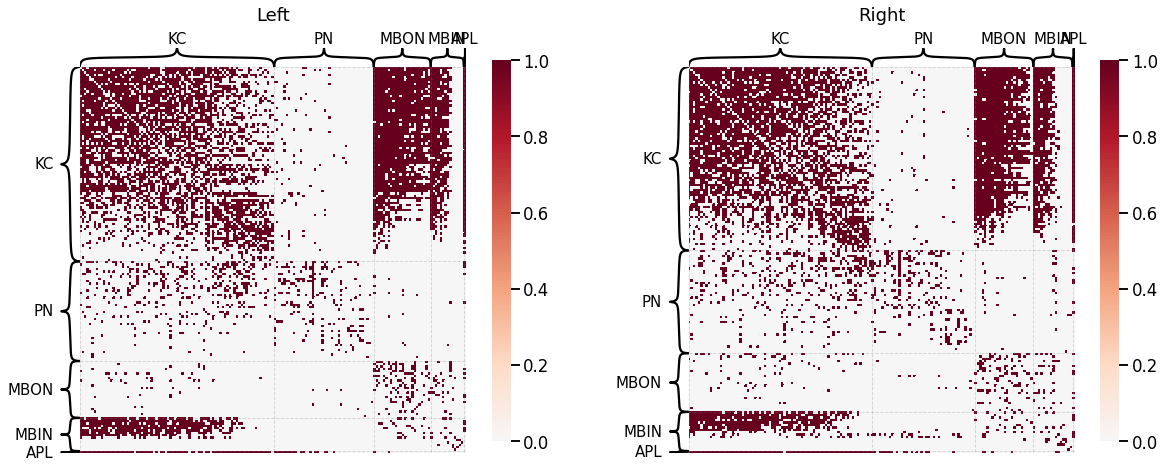

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

graspy.plot.heatmap(A_l, inner_hier_labels=nodes_l, transform='binarize', hier_label_fontsize=15, sort_nodes=True, ax=ax[0], title="Left")
graspy.plot.heatmap(A_r, inner_hier_labels=nodes_r, transform='binarize', hier_label_fontsize=15, sort_nodes=True, ax=ax[1], title="Right")

In [5]:
A_l_processed = binarize(symmetrize(A_l))
A_r_processed = binarize(symmetrize(A_r))

<AxesSubplot:title={'center':'Right'}>

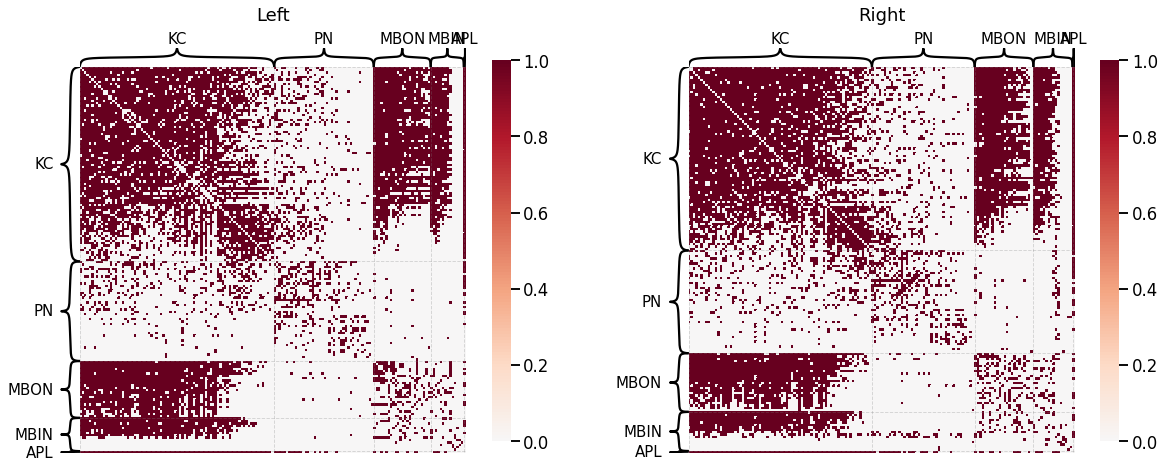

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

graspy.plot.heatmap(A_l_processed, inner_hier_labels=nodes_l, transform='binarize', hier_label_fontsize=15, sort_nodes=True, ax=ax[0], title="Left")
graspy.plot.heatmap(A_r_processed, inner_hier_labels=nodes_r, transform='binarize', hier_label_fontsize=15, sort_nodes=True, ax=ax[1], title="Right")

In [7]:
num_dims1 = select_dimension(A_l_processed)[0][-1]
num_dims2 = select_dimension(A_r_processed)[0][-1]
n_components = max(num_dims1, num_dims2)

print(n_components)

3


In [8]:
sns.set_context("talk")

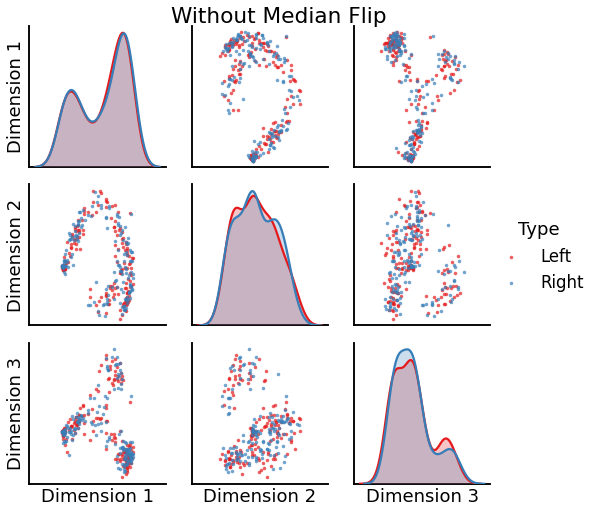

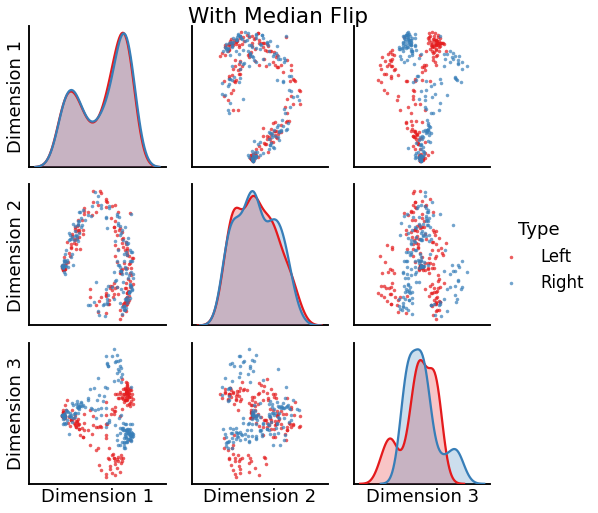

In [9]:
ase = AdjacencySpectralEmbed(n_components=n_components, diag_aug=True, check_lcc=False)
X1_hat = ase.fit_transform(A_l_processed)
X2_hat = ase.fit_transform(A_r_processed)

X1_hat_flipped, X2_hat_flipped = _median_sign_flips(X1_hat, X2_hat)

fig = graspy.plot.pairplot(np.vstack([X1_hat, X2_hat]), labels=hemispheres, title="Without Median Flip")
fig.savefig("flip_withoutgraspy.png", dpi=300, bbox_inches="tight")

fig = graspy.plot.pairplot(np.vstack([X1_hat_flipped, X2_hat_flipped]), labels=hemispheres, title="With Median Flip")
fig.savefig("flip_graspy.png", dpi=300, bbox_inches="tight")

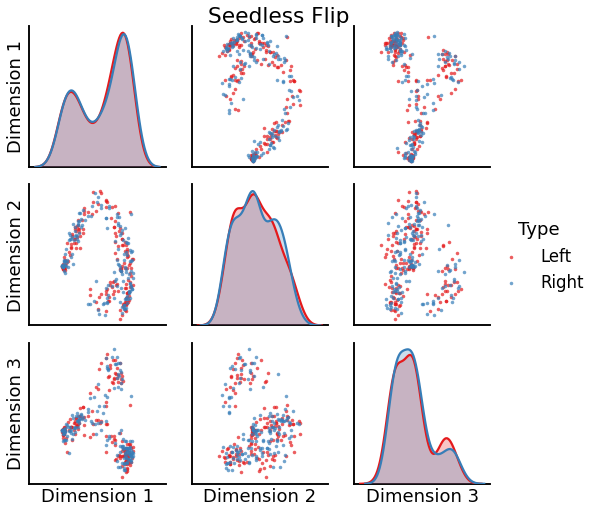

In [10]:
Q = SeedlessProcrustes().fit_predict(X1_hat, X2_hat)

X1_hat_seedless = X1_hat @ Q

fig = graspy.plot.pairplot(np.vstack([X1_hat_seedless, X2_hat]), labels=hemispheres, title="Seedless Flip")
fig.savefig("flip_seedless.png", dpi=300, bbox_inches="tight")

In [11]:
tests = [KSample('Dcorr'), KSample('MGC'), KSample('HSic', compute_distance=gaussian)]
datas = [(X1_hat, X2_hat), (X1_hat_flipped, X2_hat_flipped), (X1_hat_seedless, X2_hat)]


pvals = []
for data in datas:
    for test in tests:
        res = test.test(*data)
        pvals.append(res[1])
        
pvals = np.array(pvals).reshape(3, -1).T

df = pd.DataFrame(
    pvals, 
    columns=['W/O Flip', 'Median Flip', 'Seedless Flip'],
    index=['Dcorr', 'MGC', 'HSIC']
)

In [12]:
df

,W/O Flip,Median Flip,Seedless Flip
Dcorr,1.0,0.008655,1.000
MGC,1.0,0.001000,0.999
HSIC,1.0,0.282265,1.000


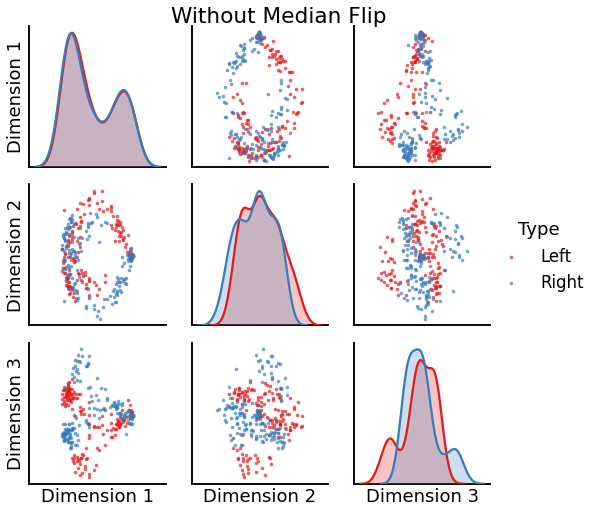

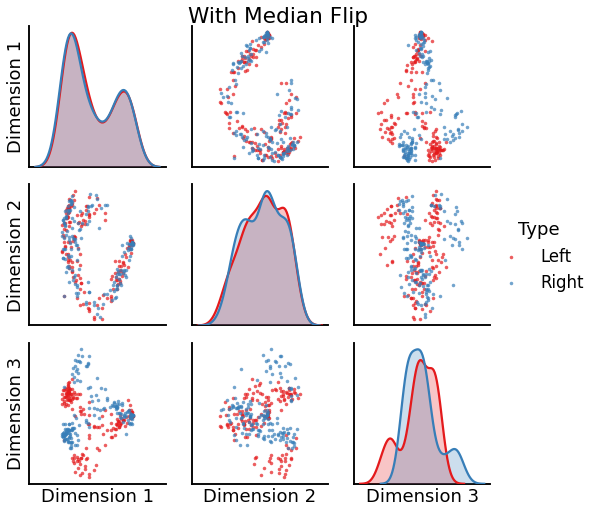

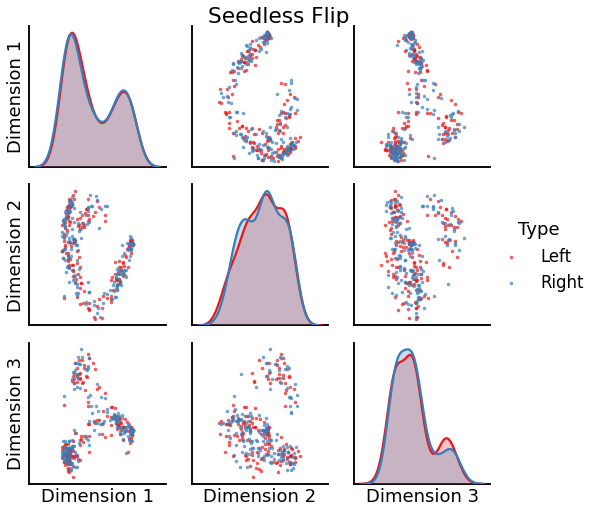

In [13]:
ase = AdjacencySpectralEmbed(n_components=n_components, algorithm='full', diag_aug=True, check_lcc=False)
X1_hat = ase.fit_transform(A_l_processed)
X2_hat = ase.fit_transform(A_r_processed)

X1_hat_flipped, X2_hat_flipped = _median_sign_flips(X1_hat, X2_hat)

fig = graspy.plot.pairplot(np.vstack([X1_hat, X2_hat]), labels=hemispheres, title="Without Median Flip")
fig.savefig("full_svd_flip_withoutgraspy.png", dpi=300, bbox_inches="tight")

fig = graspy.plot.pairplot(np.vstack([X1_hat_flipped, X2_hat_flipped]), labels=hemispheres, title="With Median Flip")
fig.savefig("full_svd_flip_graspy.png", dpi=300, bbox_inches="tight")

Q = SeedlessProcrustes().fit_predict(X1_hat, X2_hat)
X1_hat_seedless = X1_hat @ Q

fig = graspy.plot.pairplot(np.vstack([X1_hat_seedless, X2_hat]), labels=hemispheres, title="Seedless Flip")
fig.savefig("full_svd_flip_seedless.png", dpi=300, bbox_inches="tight")

In [14]:
tests = [KSample('Dcorr'), KSample('MGC'), KSample('HSic', compute_distance=gaussian)]
datas = [(X1_hat, X2_hat), (X1_hat_flipped, X2_hat_flipped), (X1_hat_seedless, X2_hat)]


pvals = []
for data in datas:
    for test in tests:
        res = test.test(*data)
        pvals.append(res[1])
        
pvals = np.array(pvals).reshape(3, -1).T

df = pd.DataFrame(
    pvals, 
    columns=['W/O Flip', 'Median Flip', 'Seedless Flip'],
    index=['Dcorr', 'MGC', 'HSIC']
)

df

,W/O Flip,Median Flip,Seedless Flip
Dcorr,0.000012,0.008655,1.000
MGC,0.001000,0.001000,0.999
HSIC,0.001844,0.282224,1.000
